In [6]:
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_federated as tff

import matplotlib.pyplot as plt

2024-08-02 17:36:02.913270: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 17:36:03.067106: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 17:36:03.067140: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 17:36:03.067654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 17:36:03.146646: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-02 17:36:03.147849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [7]:
SAVE_DIR = Path("/home/ole/masterarbeit/flidp/dataset-cache/svhn_v2")

In [6]:
train_ds = tfds.load("svhn_cropped", split="train")
test_ds = tfds.load("svhn_cropped", split="test")
len(train_ds), len(test_ds)

(73257, 26032)

In [7]:
train_df = tfds.as_dataframe(train_ds)
test_df = tfds.as_dataframe(test_ds)
len(train_df), len(test_df)

(73257, 26032)

In [13]:
TRAIN_CLIENTS = 725
TEST_CLIENTS = 250

In [8]:
train_label_counts = train_df['label'].sort_values().value_counts().to_numpy()
test_label_counts = test_df['label'].sort_values().value_counts().to_numpy()

train_label_counts, test_label_counts

(array([13861, 10585,  8497,  7458,  6882,  5727,  5595,  5045,  4948,
         4659]),
 array([5099, 4149, 2882, 2523, 2384, 2019, 1977, 1744, 1660, 1595]))

In [15]:
def assign_clients_to_df(df, num_clients):
    client_ids = np.array(range(num_clients))
    client_assignments = np.random.choice(client_ids, size=len(df))
    df['client_id'] = list(map(lambda x: f"client_{x}", client_assignments))
    return df

In [16]:
train_df_with_clients = assign_clients_to_df(train_df, TRAIN_CLIENTS)
test_df_with_clients = assign_clients_to_df(test_df, TEST_CLIENTS)
len(train_df_with_clients), len(test_df_with_clients)

(73257, 26032)

In [17]:
train_df_with_clients.head()

,image,label,client_id
0,"[[[126, 138, 136], [128, 138, 137], [129, 139,...",4,client_143
1,"[[[78, 86, 105], [80, 87, 107], [78, 85, 106],...",8,client_291
2,"[[[66, 65, 65], [72, 73, 72], [76, 77, 77], [8...",7,client_416
3,"[[[85, 83, 96], [68, 66, 80], [58, 56, 75], [5...",2,client_483
4,"[[[186, 191, 185], [186, 192, 185], [186, 193,...",6,client_488


In [18]:
def make_client_getter(df):
    def get_tf_dataset_for_client(client_id):
        client_df = df[df['client_id'] == client_id]
        client_images = tf.convert_to_tensor(client_df['image'].to_list(), dtype=tf.int64)
        client_labels = tf.convert_to_tensor(client_df['label'].to_list(), dtype=tf.int64)
        
        client_ds = tf.data.Dataset.from_tensor_slices(
            {
                'image': client_images[:], 
                'label': client_labels[:],
            }
        )
        return client_ds
    return get_tf_dataset_for_client

In [19]:
tff.simulation.datasets.save_to_sql_client_data(
    client_ids=train_df_with_clients['client_id'].unique(),
    dataset_fn=make_client_getter(train_df_with_clients),
    database_filepath=str(Path(SAVE_DIR) / 'train.sqlite'),
    allow_overwrite=True,
)
tff.simulation.datasets.save_to_sql_client_data(
    client_ids=test_df_with_clients['client_id'].unique(),
    dataset_fn=make_client_getter(test_df_with_clients),
    database_filepath=str(Path(SAVE_DIR) / 'test.sqlite'),
    allow_overwrite=True,
)

In [8]:
def load_svhn(svhn_dir: str):
    svhn_spec = {
        'image': tf.TensorSpec((32, 32, 3), dtype=tf.int64),
        'label': tf.TensorSpec((), dtype=tf.int64),
    }
    train_client_data =  tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(svhn_dir) / 'train.sqlite'), element_spec=svhn_spec, split_name=None)
    test_client_data = tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(svhn_dir) / 'test.sqlite'), element_spec=svhn_spec, split_name=None)
    return train_client_data, test_client_data

In [9]:
train_ds, test_ds = load_svhn(SAVE_DIR)

In [11]:
from tqdm.auto import tqdm

In [12]:
train_examples = 0
for _ in tqdm(iter(train_ds.create_tf_dataset_from_all_clients())):
    train_examples += 1
train_examples

73257it [01:04, 1135.63it/s]


73257

In [13]:
test_examples = 0
for _ in tqdm(iter(test_ds.create_tf_dataset_from_all_clients())):
    test_examples += 1
test_examples

26032it [00:08, 3039.97it/s]


26032

In [14]:
len(train_ds.client_ids), len(test_ds.client_ids)

(725, 250)

(<matplotlib.image.AxesImage at 0x7a52f0206e10>,
 <tf.Tensor: shape=(), dtype=int64, numpy=8>)

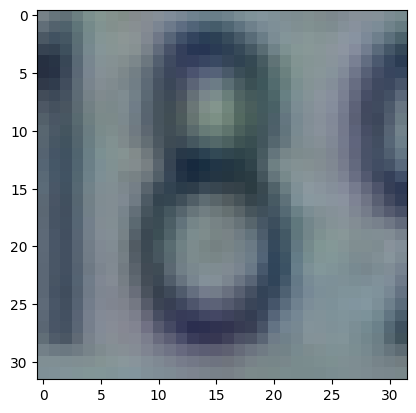

In [22]:
i = 15
for _ in range(i):
    ex = next(iter(train_ds.create_tf_dataset_from_all_clients()))
plt.imshow(ex['image']), ex['label']

(<matplotlib.image.AxesImage at 0x7a52f04a5a10>,
 <tf.Tensor: shape=(), dtype=int64, numpy=9>)

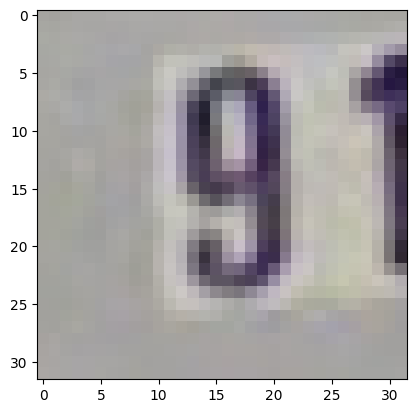

In [23]:
i = 15
for _ in range(i):
    ex = next(iter(test_ds.create_tf_dataset_from_all_clients()))
plt.imshow(ex['image']), ex['label']

In [25]:
np.max(ex['image'])

204